# Transfer Learning

Cuando realizamos Transfer Learning, tomamos un modelo ya entrenado con un conjunto de datos y utilizamos sus capas base para entrenar un nuevo modelo sobre otro dataset de interes. Dependiendo de la cantidad de datos y de lo diferentes que sean podremos evaluar como realizar dicho proceso de Transfer Learning.

Para este ejercicio, vamos a utilizar alguno de los modelos precargados en PyTorch para realizar Transfer Learning sobre el dataset de perros y gatos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 31.5 MB/s 


Podemos descargar el dataset al entorno de trabajo, desde una carpea de en Drive a partir de utilizar el ID del archivo dentro de Drive

In [2]:
# https://drive.google.com/file/d/1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-/view?usp=sharing
# El ID sera: 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
!gdown --id 1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bx73wWKNgxFZ6sSFSeaKBVcuGtdraKh-
To: /content/perros_y_gatos.zip
100% 90.8M/90.8M [00:01<00:00, 48.5MB/s]


In [3]:
!unzip /content/perros_y_gatos.zip > /dev/null

## Carga de datos con ImageDataGenerator

Dentro de PyTorch, hay un modulo llamado [`models`](https://pytorch.org/vision/stable/models.html), dentro del cual podemos encontrar algunos modelos de redes convolucionales, como los vistos en teoria, ya preentrenados y disponibles para descargar y utilizar. En este caso vamos a utilizar la arquitectura de VGG19 cuyos pesos fueron entrenados con el dataset ImageNet.

El mismo objeto que importa los pesos tiene un metodo para cargar las transformaciones que se utilizaron al momento de entrenar dicho modelo, de forma tal que podamos reutilizarlas en nuestro proceso de Transfer Learning.

In [4]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [5]:
train_set = torchvision.datasets.ImageFolder(root='./train', transform=transforms)
valid_set = torchvision.datasets.ImageFolder(root='./validation', transform=transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)


## Carga de modelo base

In [6]:
vgg19_model = torchvision.models.vgg19(weights=weights)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

## Congelo las capas de la red base

El primer paso para realizar Transfer Learning seria congelar las capas del modelo base seleccionado. Para hacer eso en PyTorch debemos poner en `False` la variable `requires_grad` de cada uno de los parametros que integran el modelo.

In [7]:
for param in vgg19_model.parameters():
    param.requires_grad = False

Luego, en base a la arquitectura particular del modelo base, modificamos las capas que nosotros queremos, asignando una nueva capa, la cual, por defecto, tendra `requires_grad = True`. Esta nueva capa debe tener tantas neuronas como clases tiene el dataset objetivo sobre el que vamos a realizar el entrenamiento.

In [8]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=2)

In [9]:
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [11]:
result_model, history = train(vgg19_model, criterion, optimizer_ft, train_loader, valid_loader, 3)

Epoch: 1/3 - Train loss 0.283281 - Train Accuracy 0.915675 - Valid Loss 0.127172 - Valid Accuracy 0.988281
Epoch: 2/3 - Train loss 0.107922 - Train Accuracy 0.975198 - Valid Loss 0.080853 - Valid Accuracy 0.992188
Epoch: 3/3 - Train loss 0.077587 - Train Accuracy 0.980655 - Valid Loss 0.062156 - Valid Accuracy 0.991211


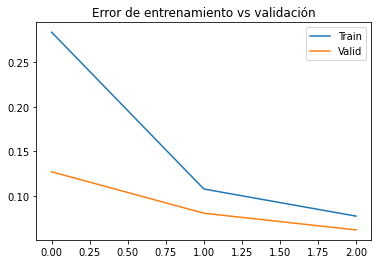

In [12]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()